# Setup

In [1]:
import os
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

## 1. Read data

In [2]:
data_folder = 'Data'
data = {}

csv_files = [f for f in os.listdir(data_folder) if re.match(r'State_Control_60sec_\d+_\d+_\d+\.csv', f)]

all_states = []
all_controls = []

for file_name in csv_files:
    # Extract initial conditions from the filename
    tokens = re.findall(r'_(\d+)_(\d+)_(\d+)\.csv$', file_name)
    if tokens:
        initial_condition = tokens[0]
        initial_str = f'init_{initial_condition[0]}_{initial_condition[1]}_{initial_condition[2]}'

        # Read the CSV file
        full_path = os.path.join(data_folder, file_name)
        csv_data = pd.read_csv(full_path)

        time = csv_data.iloc[:, 0].values
        state = csv_data.iloc[:, 1:13].values
        control = csv_data.iloc[:, 13:17].values

        # Save to dictionary with initial conditions as key
        data[initial_str] = {'time': time, 'state': state, 'control': control}

        all_states.append(state)
        all_controls.append(control)

## 2. Normalization

In [3]:
# Concatenate all state and control data to calculate normalization statistics
all_states = np.concatenate(all_states, axis=0)
all_controls = np.concatenate(all_controls, axis=0)

# Calculate mean and standard deviation for normalization
state_mean = np.mean(all_states, axis=0)
state_std = np.std(all_states, axis=0)
control_mean = np.mean(all_controls, axis=0)
control_std = np.std(all_controls, axis=0)

# Normalize the data
data_normalized = {}
for key in data.keys():
    state = data[key]['state']
    control = data[key]['control']

    state_normalized = (state - state_mean) / state_std
    control_normalized = (control - control_mean) / control_std

    data_normalized[key] = {'time': data[key]['time'], 'state': state_normalized, 'control': control_normalized}

## 3. Plot

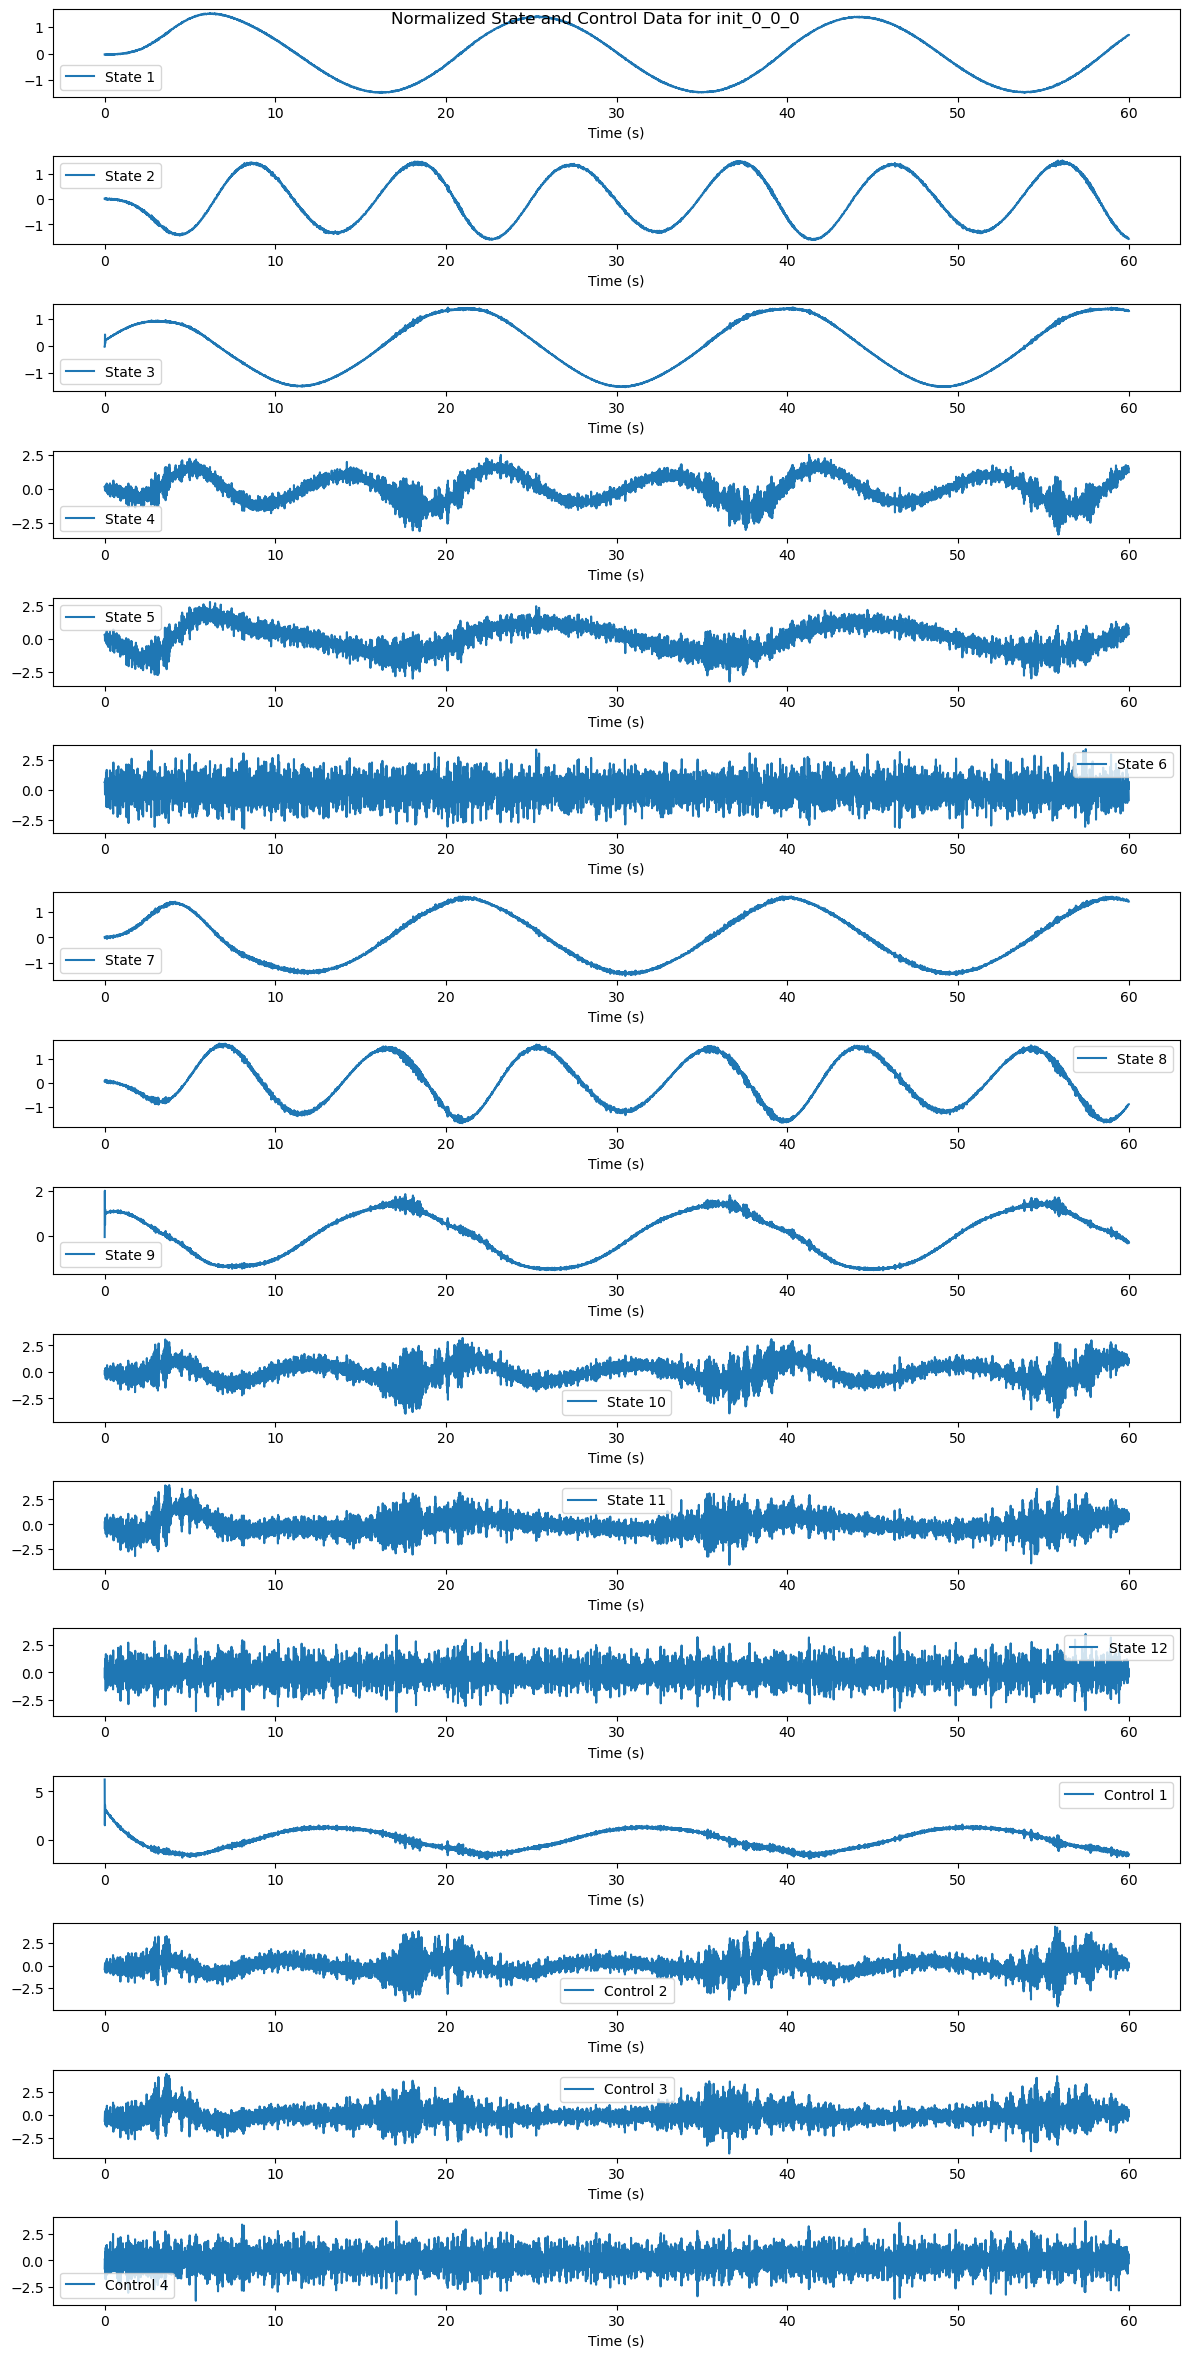

In [4]:
example_key = list(data_normalized.keys())[0]
example_data = data_normalized[example_key]

# Plot normalized states and controls
time = example_data['time']
state = example_data['state']
control = example_data['control']

fig, axes = plt.subplots(16, 1, figsize=(12, 24), tight_layout=True)

# Plot each state in a separate subplot
for i in range(state.shape[1]):
    axes[i].plot(time, state[:, i], label=f'State {i + 1}')
    axes[i].set_xlabel('Time (s)')
    axes[i].legend()

# Plot each control in a separate subplot
for i in range(control.shape[1]):
    axes[12 + i].plot(time, control[:, i], label=f'Control {i + 1}')
    axes[12 + i].set_xlabel('Time (s)')
    axes[12 + i].legend()

plt.suptitle(f'Normalized State and Control Data for {example_key}')
plt.show()

# Partition

In [6]:
total_files = len(data_normalized)

train_percent = 0.8
val_percent = 0.1

train_count = int(train_percent * total_files)
val_count = int(val_percent * total_files)
test_count = total_files - train_count - val_count

# Randomize order of senario
keys = list(data_normalized.keys())
np.random.shuffle(keys)

train_keys = keys[:train_count]
val_keys = keys[train_count:train_count + val_count]
test_keys = keys[train_count + val_count:]


# Initialize new dictionaries to store the partitioned data
train_data = {key: data_normalized[key] for key in train_keys}
val_data = {key: data_normalized[key] for key in val_keys}
test_data = {key: data_normalized[key] for key in test_keys}

print(f'Total data: {total_files} sets.\nTraining data: {train_count} sets.\nValidation data: {val_count} sets.\nTesting data: {test_count} sets.')

Total data: 27 sets.
Training data: 21 sets.
Validation data: 2 sets.
Testing data: 4 sets.


In [7]:
for key, value in train_data.items():
    print(f"Key: {key}, Time shape: {value['time'].shape}, State shape: {value['state'].shape}, Control shape: {value['control'].shape}")

Key: init_5_2_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_2_4_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_2_1_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_0_0_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_5_3_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_4_5_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_2_2_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_1_2_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_1_3_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_3_1_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_2_3_0, Time shape: (6001,), State shape: (6001, 12), Control shape: (6001, 4)
Key: init_2_5_0, Time shape: (60

# Sliding window
https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
class Window(Dataset):
    def __init__(self, time_data, state_data, control_data, input_width, prediction_width, predict_columns=None):
        """
        Initialize the StateControlScenarioDataset.
        
        Parameters:
        - state_data: DataFrame or NumPy array representing the state data.
        - control_data: DataFrame or NumPy array representing the control data.
        - input_width: The length of each input sequence
        - label_columns: The specific control columns to be used as labels.

        - input_width:         It defines the length of the input sequence that 
                                your model will look at when making a prediction.
        - label_width:         It defines the length of the target sequence that your model will predict
        - shift:               The gap between the end of the input sequence and the start of the label sequence.
        - total_window_size:   It represents the total size of the time window, starting from the 
                                beginning of the input sequence to the end of the label sequence.
        """
        # Store the data
        self.time_data = time_data
        self.state_data = state_data
        self.control_data = control_data

        # Store the sequence length
        self.input_width = input_width
        self.prediction_width = prediction_width

         # Handle label columns
        self.predict_columns = predict_columns
        if predict_columns is not None:
            # If the data is a DataFrame, convert column names to indices
            if isinstance(control_data, pd.DataFrame):
                self.label_columns_indices = [control_data.columns.get_loc(col) for col in predict_columns]
            else:
                # If it's a NumPy array, assume columns are already represented by integer indices
                self.label_columns_indices = predict_columns

        # Calculate the number of valid input-output pairs
        self.num_samples = len(state_data) - input_width - prediction_width + 1

        self.split_window()

    def split_window(self):
        # Precompute the inputs and targets
        self.inputs_time = []
        self.targets_time = []
        self.inputs = []
        self.targets = []

        for i in range(self.num_samples):
            # Time 
            input_time_sequence = self.time_data[i:i + self.input_width]
            target_time_control = self.time_data[i + self.input_width:i + self.input_width + self.prediction_width]

            # Input: the sequence of state data
            input_sequence = self.state_data[i:i + self.input_width]
            
            # Target: the next predict time steps of control data
            target_control = self.control_data[i + self.input_width:i + self.input_width + self.prediction_width]

            self.inputs_time.append(input_time_sequence)
            self.targets_time.append(target_time_control)
            self.inputs.append(input_sequence)
            self.targets.append(target_control)
        # return self.inputs, self.targets, self.inputs_time, self.targets_time

    def __repr__(self):
        self.total_window_size = self.input_width + self.prediction_width

        self.input_slice = slice(0, self.input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.predict_slice = slice(0, self.prediction_width)
        self.predict_indices = np.arange(self.total_window_size)[self.predict_slice]
        
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Predict indices: {self.predict_indices}',
            f'Label column name(s): {self.predict_columns}'])
    
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_time': torch.tensor(self.inputs_time[idx], dtype=torch.float32),
            'input': torch.tensor(self.inputs[idx], dtype=torch.float32),
            'target_time': torch.tensor(self.targets_time[idx], dtype=torch.float32),
            'target': torch.tensor(self.targets[idx], dtype=torch.float32)
        }

In [51]:
w1 = Window(time_data=train_data[key]['time'],state_data=train_data[key]['state'],control_data=train_data[key]['control'],
            input_width=10, prediction_width=10,
                     predict_columns=['thrust','roll angle','pitch angle','yaw angle']) # thrust,roll angle,pitch angle,yaw angle
w1

Total window size: 20
Input indices: [0 1 2 3 4 5 6 7 8 9]
Predict indices: [0 1 2 3 4 5 6 7 8 9]
Label column name(s): ['thrust', 'roll angle', 'pitch angle', 'yaw angle']

In [52]:
example_inputs, example_predict, example_in_time, example_pre_time = w1.split_window()
example_inputs = np.array(example_inputs)
example_predict = np.array(example_predict)

print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_predict.shape}')

Inputs shape: (5982, 10, 12)
Labels shape: (5982, 10, 4)


## 1. Visualization

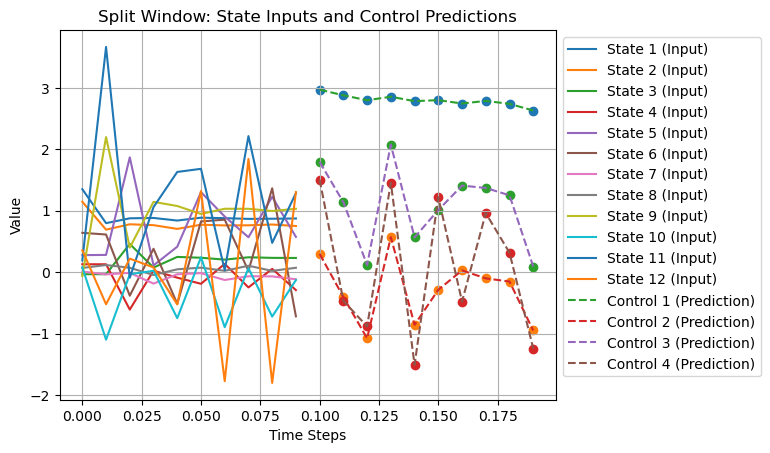

In [62]:
example_idx = 0
example_data = w1[example_idx]

example_time_inputs = example_data['input_time'].numpy()
example_time_predict = example_data['target_time'].numpy()

example_inputs = example_data['input'].numpy()
example_predict = example_data['target'].numpy()

input_time = example_time_inputs
prediction_time = example_time_predict

plt.figure

# Plotting the state input sequence
for i in range(example_inputs.shape[1]):
    plt.plot(input_time, example_inputs[:, i], label=f'State {i + 1} (Input)', linestyle='-')

# Plotting the control target sequence (predicted values)
for i in range(example_predict.shape[1]):
    plt.plot(prediction_time, example_predict[:, i], label=f'Control {i + 1} (Prediction)', linestyle='--')
    plt.scatter(prediction_time, example_predict[:, i], marker='o')

# Labels and legend
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Split Window: State Inputs and Control Predictions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()

# Training

## 1. Setup

In [92]:
batch_size=100
# Create data loaders for training scenarios
train_loaders = []
for key in train_data.keys():
    time_data = train_data[key]['time']
    state_data = train_data[key]['state']
    control_data = train_data[key]['control']
    scenario_dataset = Window(time_data=train_data[key]['time'],state_data=train_data[key]['state'],control_data=train_data[key]['control'],
                                input_width=10, prediction_width=10,
                                predict_columns=['thrust','roll angle','pitch angle','yaw angle'])
    scenario_loader = DataLoader(scenario_dataset, batch_size=batch_size, shuffle=False)
    train_loaders.append(scenario_loader)


In [93]:
# Similarly, create data loaders for validation and testing scenarios if needed
val_loaders = []
for key in val_data.keys():
    time_data = val_data[key]['time']
    state_data = val_data[key]['state']
    control_data = val_data[key]['control']
    scenario_dataset = Window(time_data=val_data[key]['time'],state_data=val_data[key]['state'],control_data=val_data[key]['control'],
                                input_width=10, prediction_width=10,
                                predict_columns=['thrust','roll angle','pitch angle','yaw angle'])
    scenario_loader = DataLoader(scenario_dataset, batch_size=batch_size, shuffle=False)
    val_loaders.append(scenario_loader)

test_loaders = []
for key in test_data.keys():
    time_data = test_data[key]['time']
    state_data = test_data[key]['state']
    control_data = test_data[key]['control']
    scenario_dataset = Window(time_data=test_data[key]['time'],state_data=test_data[key]['state'],control_data=test_data[key]['control'],
                                input_width=10, prediction_width=10,
                                predict_columns=['thrust','roll angle','pitch angle','yaw angle'])
    scenario_loader = DataLoader(scenario_dataset, batch_size=batch_size, shuffle=False)
    test_loaders.append(scenario_loader)

## 2. Use GPU

In [94]:
print(torch.cuda.is_available())

True


## 3. Define model
https://www.geeksforgeeks.org/implementing-recurrent-neural-networks-in-pytorch/

In [ ]:
# class SimpleRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(SimpleRNN, self).__init__()
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
#         out, _ = self.rnn(x, h0)
#         out = self.fc(out)
#         return out

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out) 
        # # Use only the last time step
        # out = self.fc(out[:, -1, :])
        return out

input_size = 12
hidden_size = 64
output_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleRNN(input_size, hidden_size, output_size).to(device)
print(f'Using device: {device}')

Using device: cuda


In [118]:
output_folder = 'Training_output_draft'
# TensorBoard setup
writer = SummaryWriter(log_dir=os.path.join(output_folder, 'tensorboard_LSTM_logs500_lr301'))

## 4. Train model
https://pytorch.org/tutorials/beginner/saving_loading_models.html

state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.

In [126]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    total_samples = 0

    for scenario_loader in train_loaders:  # Iterate through each scenario-specific loader
        for batch in scenario_loader:
            state_sequence = batch['input'].to(device)  # Shape: (batch_size, seq_length, input_size)
            control_target = batch['target'].to(device)  # Shape: (batch_size, output_size)


            # Forward pass
            control_pred = model(state_sequence)

            # Compute loss
            loss = criterion(control_pred, control_target)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            epoch_loss += loss.item() * state_sequence.size(0)
            total_samples += state_sequence.size(0)
    
    # Calculate and print average loss for the epoch
    avg_loss = epoch_loss / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    writer.add_scalar('Training Loss', avg_loss, epoch)

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0  # Total accumulated validation loss
    total_val_samples = 0  # Total number of validation samples

    with torch.no_grad():  # Disable gradient calculations
        for val_loader in val_loaders:
            for batch in val_loader:
                state_sequence = batch['input'].to(device)  # Shape: (batch_size, seq_length, input_size)
                control_target = batch['target'].to(device)  # Shape: (batch_size, output_size)

                # Forward pass
                control_pred = model(state_sequence)

                # Compute loss
                loss = criterion(control_pred, control_target)

                # Accumulate validation loss and total samples
                total_val_loss += loss.item() * state_sequence.size(0)
                total_val_samples += state_sequence.size(0)

    # Compute the average validation loss for the epoch
    avg_val_loss = total_val_loss / total_val_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')
    writer.add_scalar('Validation Loss', avg_val_loss, epoch)

# Save the trained model
model_save_path = os.path.join(output_folder, 'trained_model.pth')
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

print("Training finished!")
writer.close()

Epoch [1/500], Loss: 0.7972
Epoch [1/500], Validation Loss: 0.7230
Epoch [2/500], Loss: 0.6627
Epoch [2/500], Validation Loss: 0.5890
Epoch [3/500], Loss: 0.5668
Epoch [3/500], Validation Loss: 0.5532
Epoch [4/500], Loss: 0.5487
Epoch [4/500], Validation Loss: 0.5421
Epoch [5/500], Loss: 0.5400
Epoch [5/500], Validation Loss: 0.5349
Epoch [6/500], Loss: 0.5339
Epoch [6/500], Validation Loss: 0.5295
Epoch [7/500], Loss: 0.5290
Epoch [7/500], Validation Loss: 0.5250
Epoch [8/500], Loss: 0.5247
Epoch [8/500], Validation Loss: 0.5208
Epoch [9/500], Loss: 0.5206
Epoch [9/500], Validation Loss: 0.5168
Epoch [10/500], Loss: 0.5167
Epoch [10/500], Validation Loss: 0.5130
Epoch [11/500], Loss: 0.5130
Epoch [11/500], Validation Loss: 0.5092
Epoch [12/500], Loss: 0.5093
Epoch [12/500], Validation Loss: 0.5054
Epoch [13/500], Loss: 0.5056
Epoch [13/500], Validation Loss: 0.5017
Epoch [14/500], Loss: 0.5021
Epoch [14/500], Validation Loss: 0.4982
Epoch [15/500], Loss: 0.4987
Epoch [15/500], Validat

# Plot

C:\Users\liu12\AppData\Local\Temp\ipykernel_20748\1734633152.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab10')(i)


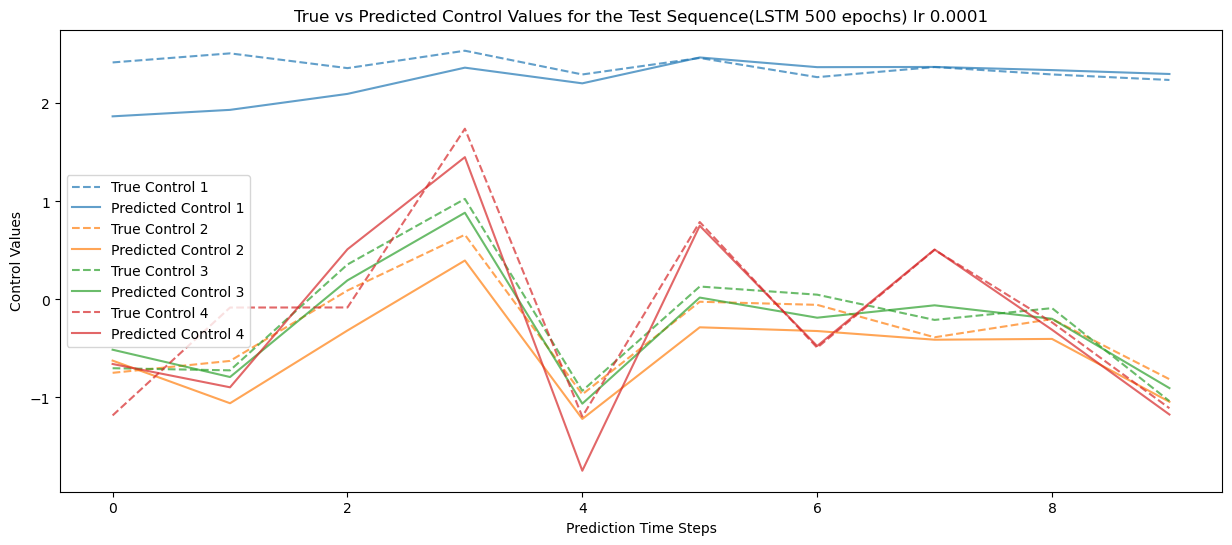

In [128]:
# Set the model to evaluation mode
model.eval()

test_loader = test_loaders[0]
example_batch = next(iter(test_loader))  # Get the first batch
input_sequence = example_batch['input'] 
true_output = example_batch['target'] 

# Move to device
input_sequence = input_sequence.to(device)
true_output = true_output.to(device)

# Predict using the model
with torch.no_grad():
    predicted_output = model(input_sequence)

# Move data to CPU for plotting
true_output = true_output.cpu().numpy()
predicted_output = predicted_output.cpu().numpy()


sequence_idx = 20
true_ctrl = true_output[sequence_idx]     # Shape: (prediction_width, output_size)
pred_ctrl = predicted_output[sequence_idx] # Shape: (prediction_width, output_size)

# Plot true vs predicted control values over the prediction time steps
plt.figure(figsize=(15, 6))

# Create a time range for the predicted horizon
pred_time_steps = range(len(true_ctrl))

# Plotting true vs predicted control values for each control variable
for i in range(len(true_ctrl[0])):
    color = plt.cm.get_cmap('tab10')(i)
    plt.plot(pred_time_steps, true_ctrl[:, i], linestyle='--', color=color, label=f'True Control {i+1}', alpha=0.7)
    plt.plot(pred_time_steps, pred_ctrl[:, i], linestyle='-', color=color, label=f'Predicted Control {i+1}', alpha=0.7)

plt.xlabel('Prediction Time Steps')
plt.ylabel('Control Values')
plt.title('True vs Predicted Control Values for the Test Sequence(LSTM 500 epochs) lr 0.0001')
plt.legend()
plt.show()
